In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# # Install transformers library
# !pip3 install transformers
# !pip3 install torch
# !pip3 install torch torchvision torchaudio

# https://wandb.ai/ivangoncharov/FinBERT_Sentiment_Analysis_Project/reports/Financial-Sentiment-Analysis-on-Stock-Market-Headlines-With-FinBERT-HuggingFace--VmlldzoxMDQ4NjM0#finbert-using-huggingface

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Specify the path to the compiled JSON file
compiled_json_path = "../dataset/raw_final.json"

# Read the JSON file into a DataFrame
df = pd.read_json(compiled_json_path, orient='records')

# Remove duplicate rows based on all columns
df_no_duplicates = df.drop_duplicates()

# Remove duplicates based on specific columns
columns_to_check = ['Headline']
df_no_duplicates_specific = df_no_duplicates.drop_duplicates(subset=columns_to_check)

# Reset the index
final_df = df_no_duplicates_specific.reset_index(drop=True)

# Convert the 'Date' column to datetime format and extract only the date part
final_df['Date'] = final_df['Date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S').date())

# Sort the DataFrame by the 'Date' column
final_df_sorted = final_df.sort_values(by='Date')

# Reset the index again after sorting
final_df_sorted_reset = final_df_sorted.reset_index(drop=True)

# Display the resulting DataFrame with the reset index
final_df_sorted_reset


,Date,Headline
0,2010-01-04,Popbox leads CES internet TV showtime
1,2010-01-06,Disney and rivals square up in format war
2,2010-01-07,Internet-enabled TVs to feature ‘app stores’
3,2010-01-07,Warner seals DVD deal with Netflix
4,2010-01-10,CES 2010 – best in show
...,...,...
6540,2024-01-26,Netflix Offers Subscribers a Whole Cable Bundle
6541,2024-01-26,PayPal Movie Aims to Bring Elon Musk and Peter...
6542,2024-01-27,Wall Street Gets a Warning About Getting the U...
6543,2024-01-28,Why Shari Redstone Is Ready to Surrender Her M...


## Filtering netflix

In [3]:

# Replace 'final_df_sorted_reset' with the actual name of your DataFrame
selected_rows = final_df_sorted_reset[final_df_sorted_reset['Headline'].str.contains('netflix', case=False)]

# Display the selected rows
selected_rows


,Date,Headline
3,2010-01-07,Warner seals DVD deal with Netflix
6,2010-01-28,Netflix shares leap 10%
27,2010-05-05,Seagate media player gets flexible with Netflix
42,2010-08-10,Netflix in streaming deal with pay-TV
90,2010-12-09,Netflix challenge to traditional TV
...,...,...
6529,2023-12-27,Bitconned review — Netflix documentary about a...
6531,2023-12-28,‘Shakeout has begun’ after $5bn streaming loss...
6535,2024-01-25,"Bloomberg Surveillance: Tesla Slumps, Netflix ..."
6539,2024-01-26,Netflix Eyes Best Week Since 2022 on Stunning ...


## visualisation

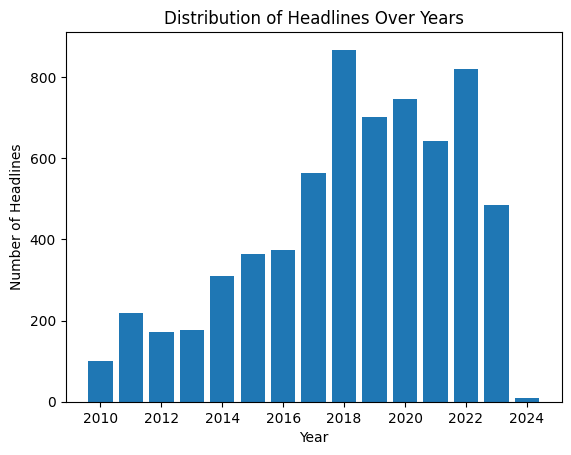

In [4]:
final_df_sorted_reset['Year'] = final_df_sorted_reset['Date'].apply(lambda x: x.year)

# Group by year and count the occurrences
yearly_distribution = final_df_sorted_reset.groupby('Year').size()

# Plot the distribution
plt.bar(yearly_distribution.index, yearly_distribution)
plt.xlabel('Year')
plt.ylabel('Number of Headlines')
plt.title('Distribution of Headlines Over Years')
plt.show()

## NLP

In [5]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Check if the model is already saved locally
try:
    model = AutoModelForSequenceClassification.from_pretrained("./finbert_model")
    print("Model loaded from local directory.")
except:
    # If not, download and save the model
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    model.save_pretrained("./finbert_model")
    print("Model downloaded and saved locally.")

# Assuming 'selected_rows' is your DataFrame containing the headlines
# Replace 'selected_rows' with the actual name of your DataFrame
headlines_list = selected_rows['Headline'].tolist()
dates_list = selected_rows['Date'].tolist()

inputs = tokenizer(headlines_list, padding=True, truncation=True, return_tensors='pt')

# Run inference
outputs = model(**inputs)

# Post-process outputs with softmax activation
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Create a DataFrame for W&B Tables
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Date': dates_list,
         'Headline': headlines_list,
         'Positive': positive,
         'Negative': negative,
         'Neutral': neutral}

df_results = pd.DataFrame(table, columns=["Date", "Headline", "Positive", "Negative", "Neutral"])

# Display the results
df_results.head(5)


Model loaded from local directory.


,Date,Headline,Positive,Negative,Neutral
0,2010-01-07,Warner seals DVD deal with Netflix,0.659936,0.015980,0.324085
1,2010-01-28,Netflix shares leap 10%,0.493929,0.027924,0.478147
2,2010-05-05,Seagate media player gets flexible with Netflix,0.759546,0.011274,0.229180
3,2010-08-10,Netflix in streaming deal with pay-TV,0.191582,0.011374,0.797044
4,2010-12-09,Netflix challenge to traditional TV,0.125666,0.024926,0.849408


In [6]:

df_results.to_csv("output_results.csv", index=False)
